<a href="https://colab.research.google.com/github/elvansahin/alcf-ml-homeworks/blob/main/Copy_of_01_introduction_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Neural Networks
Author: Marieme Ngom, adapting materials from Bethany Lusch, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, and Tanwi Mallick.

This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset.

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/mnist_task.png?raw=1"  align="left"/>



In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:01<00:00, 6.18MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.18MB/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.11MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.76MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Let's take a closer look. Here are the first 10 training digits:

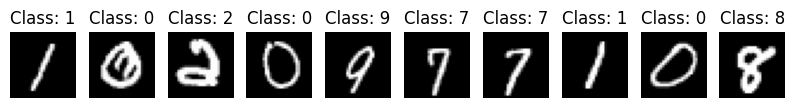

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
Let's begin with a simple linear model: linear regression, like last week.
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product. If the target output is a vector as well, then the multiplication becomes matrix multiplication.

Note, like before, we consider multiple examples at once, adding another dimension to the input.


 <img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/LinearModel_1.png?raw=1"  align="center"/>



The linear layers in PyTorch perform a basic $xW + b$. These "fully connected" layers connect each input to each output with some weight parameter. We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the class label and minimizing mean squared error to work well - the model would output labels like 3.55 and 2.11 instead of skipping to integers.

We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b). Last week, we used mean squared error (MSE), but this week let's make two changes that make more sense for classification:
    - Change the output to be a length-10 vector of class probabilities (0 to 1, adding to 1).
    - Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd), like last week. For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

- A learning rate. As we learned last week, the learning rate controls how far we move during each step.

In [6]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # First, we need to convert the input image to a vector by using
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()

        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)

    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [7]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.






In [8]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [9]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [10]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

In [11]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.5032944432894388, accuracy: 87.62708333333333
Epoch 0: val. loss: 0.4955129306367103, val. accuracy: 87.52499999999999
Epoch 1: training loss: 0.4220785075823466, accuracy: 88.96041666666666
Epoch 1: val. loss: 0.4127881298673914, val. accuracy: 88.9
Epoch 2: training loss: 0.3878137603998184, accuracy: 89.67083333333333
Epoch 2: val. loss: 0.3779678078407937, val. accuracy: 89.43333333333334
Epoch 3: training loss: 0.36769934991995495, accuracy: 90.07291666666667
Epoch 3: val. loss: 0.3576743404598946, val. accuracy: 89.90833333333333
Epoch 4: training loss: 0.3540336361328761, accuracy: 90.42291666666667
Epoch 4: val. loss: 0.3440136392699911, val. accuracy: 90.28333333333333
CPU times: user 1min 9s, sys: 159 ms, total: 1min 9s
Wall time: 1min 10s


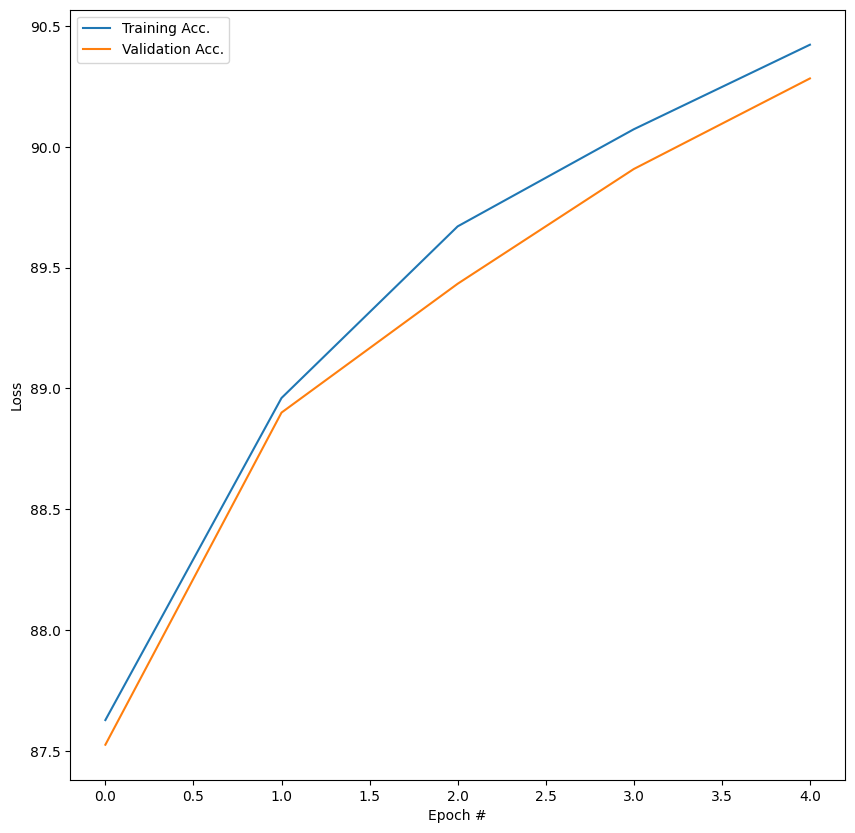

In [12]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

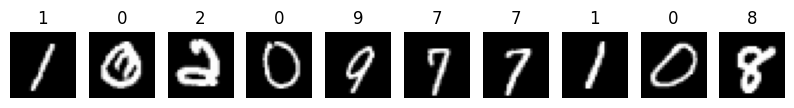

In [13]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc.

# Prediction

Let's see how our model generalizes to the unseen test data.



In [14]:
#create dataloader for test data
# The dataloader makes our dataset iterable
batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [15]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.3324, test accuracy: 90.92%


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [16]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])

    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Here are the first 10 images from the test data that this small model classified to a wrong class:



Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


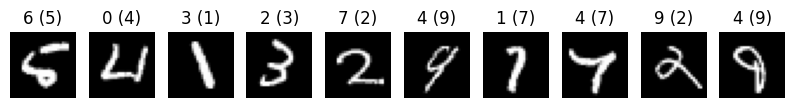

In [17]:
show_failures(linear_model, test_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Multilayer Model
Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/shallow_nn.png?raw=1"  align="left"/>

The output of this NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex tasks. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/activation.jpeg?raw=1"  align="center"/>

Adding more layers to obtain a deep neural network:
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/deep_nn_annotated.jpg?raw=1"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data, just like fitting overly complicated polynomials:
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/bias_vs_variance.png?raw=1"  align="left"/>


Vizualization wrt to the accuracy and loss (Image source: [Baeldung](https://www.baeldung.com/cs/ml-underfitting-overfitting)):
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/acc_under_over.webp?raw=1"  align="center"/>


To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
Vanishing gradients: Gradients become small as they propagate backward through the layers. Squashing activation functions like sigmoid or tanh could cause this.

Exploding gradients: Gradients grow exponentially usually due to "poor" weight initialization.

<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [18]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [19]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [20]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.7500098155339558, accuracy: 78.05833333333332
Epoch 0: val. loss: 0.7471161668604993, val. accuracy: 77.54166666666666
Epoch 1: training loss: 0.40683598736921944, accuracy: 88.32083333333334
Epoch 1: val. loss: 0.40274749823073125, val. accuracy: 88.08333333333334
Epoch 2: training loss: 0.31164117511113487, accuracy: 90.93958333333333
Epoch 2: val. loss: 0.3087650163376585, val. accuracy: 90.875
Epoch 3: training loss: 0.25775302706162134, accuracy: 92.52083333333333
Epoch 3: val. loss: 0.25888365174227573, val. accuracy: 92.30833333333334
Epoch 4: training loss: 0.21200885275999706, accuracy: 93.93333333333334
Epoch 4: val. loss: 0.21509290090266694, val. accuracy: 93.51666666666667
CPU times: user 1min 14s, sys: 139 ms, total: 1min 14s
Wall time: 1min 14s


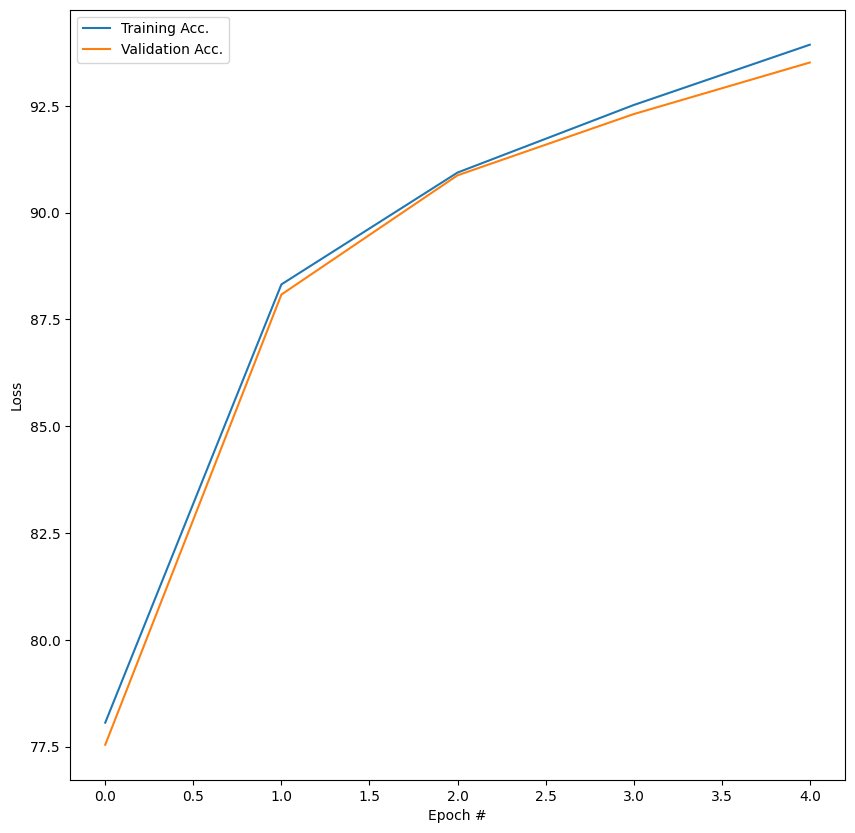

In [21]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


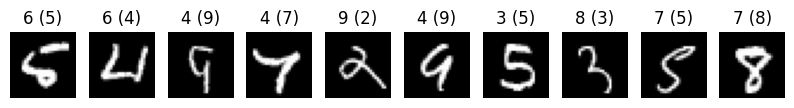

In [22]:
show_failures(nonlinear_model, test_dataloader)

# Recap
To train and validate a neural network model, you need:
- Data split into training/validation/test sets,
- A model with parameters to learn,
- An appropriate loss function,
- An optimizer (with tunable parameters such as learning rate, weight decay etc.) used to learn the parameters of the model.


# Homework

1. Compare the quality of your model when using different:
 - batch sizes,
 - learning rates,
 - activation functions.

3. Bonus: What is a learning rate scheduler?

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization.

**Testing Batch Sizes**
Once we increase the number of batch size, the accuracy decreases.

Batch Size 16, Epoch 0: training loss: 0.21302932858063528, accuracy: 93.69583333333334
Batch Size 16, Epoch 0: val. loss: 0.2124580126181245, val. accuracy: 93.43333333333334
Batch Size 16, Epoch 1: training loss: 0.15687780198516946, accuracy: 95.34375
Batch Size 16, Epoch 1: val. loss: 0.16312821212535103, val. accuracy: 94.86666666666666
Batch Size 16, Epoch 2: training loss: 0.12453495406691217, accuracy: 96.31041666666667
Batch Size 16, Epoch 2: val. loss: 0.13934783209922413, val. accuracy: 95.76666666666667
Batch Size 16, Epoch 3: training loss: 0.106766688769431, accuracy: 96.83541666666666
Batch Size 16, Epoch 3: val. loss: 0.12575286433581884, val. accuracy: 96.25833333333334
Batch Size 16, Epoch 4: training loss: 0.09239174773688137, accuracy: 97.19583333333334
Batch Size 16, Epoch 4: val. loss: 0.11826782416505739, val. accuracy: 96.34166666666667


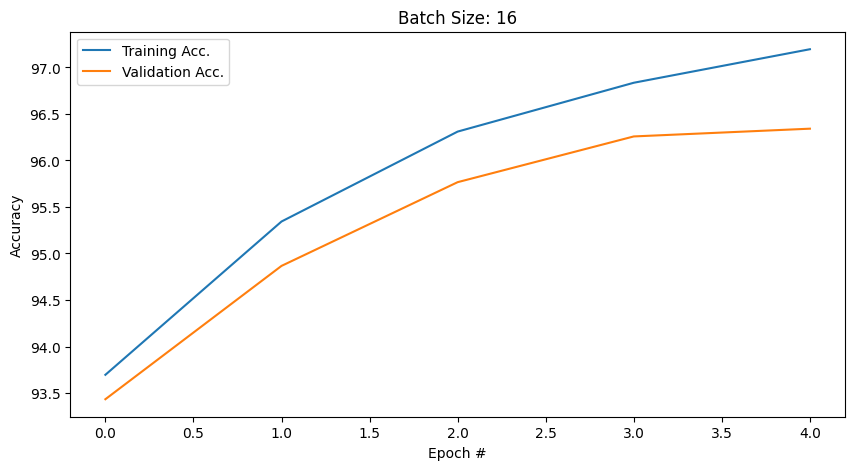

Batch Size 32, Epoch 0: training loss: 0.2701238916901251, accuracy: 92.25208333333333
Batch Size 32, Epoch 0: val. loss: 0.26408223164081573, val. accuracy: 92.0
Batch Size 32, Epoch 1: training loss: 0.1920400188708057, accuracy: 94.26458333333333
Batch Size 32, Epoch 1: val. loss: 0.1913288526038329, val. accuracy: 94.25833333333333
Batch Size 32, Epoch 2: training loss: 0.14822135839487116, accuracy: 95.63958333333333
Batch Size 32, Epoch 2: val. loss: 0.15520663252224526, val. accuracy: 95.10833333333333
Batch Size 32, Epoch 3: training loss: 0.12313827669651559, accuracy: 96.375
Batch Size 32, Epoch 3: val. loss: 0.13398871327067416, val. accuracy: 96.00833333333333
Batch Size 32, Epoch 4: training loss: 0.10468143126787618, accuracy: 96.93333333333334
Batch Size 32, Epoch 4: val. loss: 0.12285859736303488, val. accuracy: 96.25


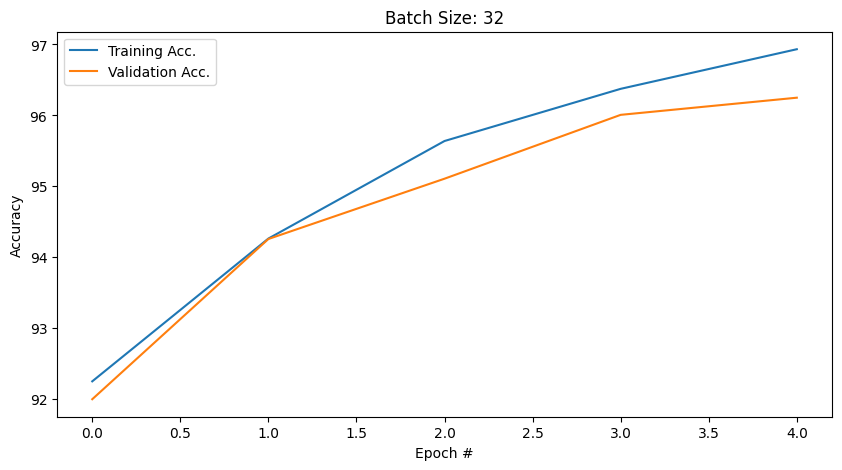

Batch Size 64, Epoch 0: training loss: 0.3540691224137942, accuracy: 90.24583333333334
Batch Size 64, Epoch 0: val. loss: 0.34290921458221496, val. accuracy: 90.04166666666666
Batch Size 64, Epoch 1: training loss: 0.25595428667465847, accuracy: 92.69791666666667
Batch Size 64, Epoch 1: val. loss: 0.25004986503181303, val. accuracy: 92.375
Batch Size 64, Epoch 2: training loss: 0.20643302624424298, accuracy: 94.07083333333334
Batch Size 64, Epoch 2: val. loss: 0.20502978852613174, val. accuracy: 94.025
Batch Size 64, Epoch 3: training loss: 0.1764555329779784, accuracy: 94.85208333333334
Batch Size 64, Epoch 3: val. loss: 0.1779406378045678, val. accuracy: 94.79166666666666
Batch Size 64, Epoch 4: training loss: 0.15502219013373056, accuracy: 95.50416666666666
Batch Size 64, Epoch 4: val. loss: 0.16113938894519148, val. accuracy: 95.3


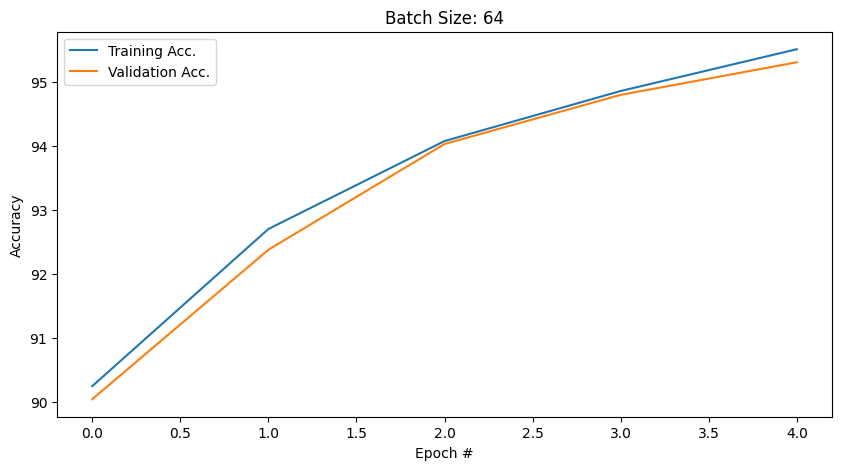

Batch Size 128, Epoch 0: training loss: 0.4870157812436422, accuracy: 86.79583333333333
Batch Size 128, Epoch 0: val. loss: 0.48076611567050853, val. accuracy: 87.225
Batch Size 128, Epoch 1: training loss: 0.3492528198162715, accuracy: 90.05625
Batch Size 128, Epoch 1: val. loss: 0.3414206175093955, val. accuracy: 90.19166666666666
Batch Size 128, Epoch 2: training loss: 0.2932815911769867, accuracy: 91.6375
Batch Size 128, Epoch 2: val. loss: 0.28778504833896107, val. accuracy: 91.66666666666666
Batch Size 128, Epoch 3: training loss: 0.25426213123401004, accuracy: 92.77499999999999
Batch Size 128, Epoch 3: val. loss: 0.25043849345851454, val. accuracy: 92.65
Batch Size 128, Epoch 4: training loss: 0.2272509452899297, accuracy: 93.49374999999999
Batch Size 128, Epoch 4: val. loss: 0.2251755438269453, val. accuracy: 93.29166666666666


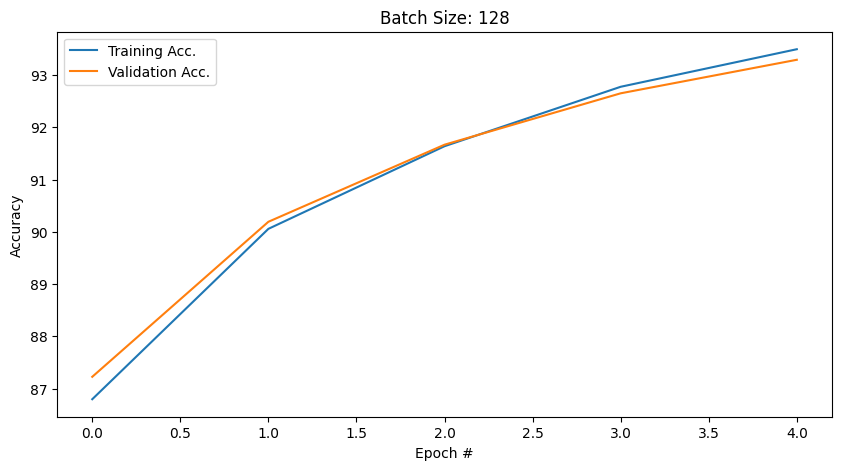

In [30]:
# Hyperparameters (constant learning rate and activation function)
learning_rate = 0.05
activation_function = nn.ReLU()

# Different batch sizes to test
batch_sizes = [16, 32, 64, 128]
epochs = 5

for batch_size in batch_sizes:
    # Initialize dataloaders for the current batch size
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

    # Model, loss function, and optimizer
    nonlinear_model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 50),
        activation_function,
        nn.Dropout(0.2),
        nn.Linear(50, 50),
        activation_function,
        nn.Linear(50, 10)
    )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=learning_rate)

    train_acc_all, val_acc_all = [], []

    # Training loop
    for j in range(epochs):
        train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

        # Training evaluation
        acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
        train_acc_all.append(acc)
        print(f"Batch Size {batch_size}, Epoch {j}: training loss: {loss}, accuracy: {acc}")

        # Validation evaluation
        val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
        val_acc_all.append(val_acc)
        print(f"Batch Size {batch_size}, Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

    # Plotting results
    plt.figure(figsize=(10, 5))
    plt.plot(range(epochs), train_acc_all, label='Training Acc.')
    plt.plot(range(epochs), val_acc_all, label='Validation Acc.')
    plt.title(f'Batch Size: {batch_size}')
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

**Testing Learning Rates**
Once we incease the learning rate, the accuracy increases in both training and validation data.

Learning Rate 0.01, Epoch 0: training loss: 2.0294571158091226, accuracy: 49.92916666666667
Learning Rate 0.01, Epoch 0: val. loss: 2.029146916054665, val. accuracy: 50.03333333333333
Learning Rate 0.01, Epoch 1: training loss: 1.2073455133438111, accuracy: 73.64583333333333
Learning Rate 0.01, Epoch 1: val. loss: 1.2037027465536239, val. accuracy: 73.91666666666666
Learning Rate 0.01, Epoch 2: training loss: 0.7596784776051839, accuracy: 80.50833333333334
Learning Rate 0.01, Epoch 2: val. loss: 0.7552397847175598, val. accuracy: 80.80833333333334
Learning Rate 0.01, Epoch 3: training loss: 0.5933791849613189, accuracy: 84.0125
Learning Rate 0.01, Epoch 3: val. loss: 0.5889300935445948, val. accuracy: 83.99166666666666
Learning Rate 0.01, Epoch 4: training loss: 0.508335548321406, accuracy: 86.14583333333333
Learning Rate 0.01, Epoch 4: val. loss: 0.5033893772262208, val. accuracy: 86.1


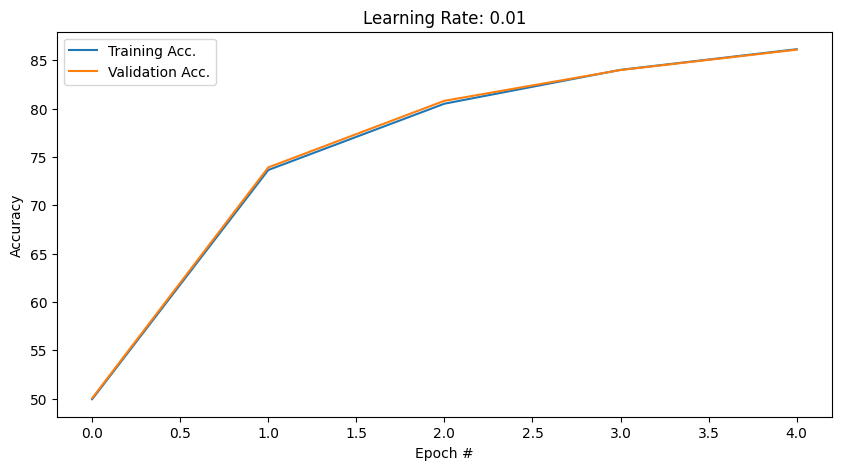

Learning Rate 0.05, Epoch 0: training loss: 0.5041969908873241, accuracy: 86.42708333333333
Learning Rate 0.05, Epoch 0: val. loss: 0.4982931693183615, val. accuracy: 86.49166666666666
Learning Rate 0.05, Epoch 1: training loss: 0.3466387435992559, accuracy: 90.16666666666666
Learning Rate 0.05, Epoch 1: val. loss: 0.34047690683856924, val. accuracy: 90.09166666666667
Learning Rate 0.05, Epoch 2: training loss: 0.289649098833402, accuracy: 91.70208333333333
Learning Rate 0.05, Epoch 2: val. loss: 0.2842003972606456, val. accuracy: 91.64166666666667
Learning Rate 0.05, Epoch 3: training loss: 0.24989178200562795, accuracy: 92.72916666666666
Learning Rate 0.05, Epoch 3: val. loss: 0.2455402970948118, val. accuracy: 92.78333333333333
Learning Rate 0.05, Epoch 4: training loss: 0.22023009808858235, accuracy: 93.675
Learning Rate 0.05, Epoch 4: val. loss: 0.216905377963756, val. accuracy: 93.70833333333334


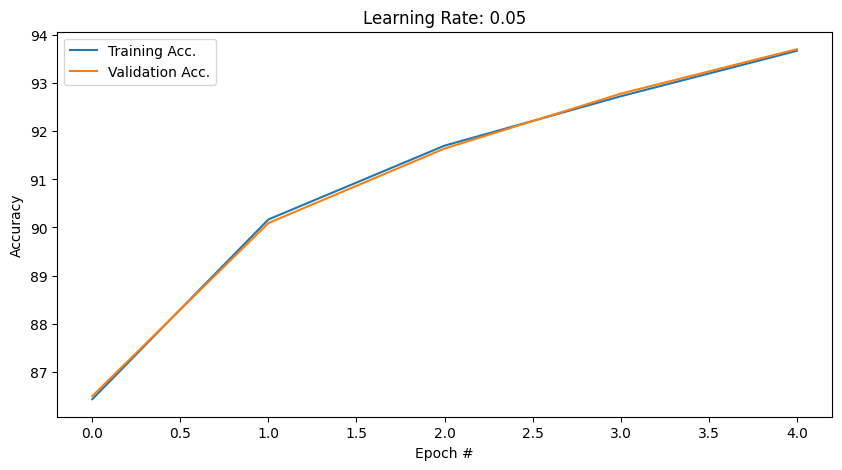

Learning Rate 0.1, Epoch 0: training loss: 0.3493943374951681, accuracy: 90.17708333333333
Learning Rate 0.1, Epoch 0: val. loss: 0.34010733331137516, val. accuracy: 90.225
Learning Rate 0.1, Epoch 1: training loss: 0.2500446805357933, accuracy: 92.98541666666667
Learning Rate 0.1, Epoch 1: val. loss: 0.24298655249653978, val. accuracy: 92.975
Learning Rate 0.1, Epoch 2: training loss: 0.20724065613746642, accuracy: 94.01041666666666
Learning Rate 0.1, Epoch 2: val. loss: 0.20584683389739789, val. accuracy: 93.85
Learning Rate 0.1, Epoch 3: training loss: 0.17691742024819057, accuracy: 94.89583333333333
Learning Rate 0.1, Epoch 3: val. loss: 0.17777838304321816, val. accuracy: 94.80833333333332
Learning Rate 0.1, Epoch 4: training loss: 0.15415883462627727, accuracy: 95.5875
Learning Rate 0.1, Epoch 4: val. loss: 0.15750426822837363, val. accuracy: 95.23333333333333


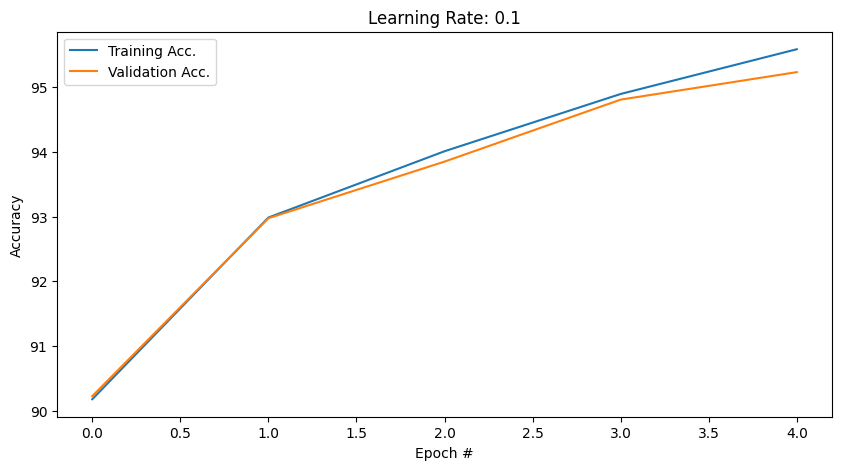

Learning Rate 0.5, Epoch 0: training loss: 0.20405829288562138, accuracy: 93.82916666666667
Learning Rate 0.5, Epoch 0: val. loss: 0.20174001545665113, val. accuracy: 93.8
Learning Rate 0.5, Epoch 1: training loss: 0.1563910331726074, accuracy: 95.29375
Learning Rate 0.5, Epoch 1: val. loss: 0.16616605598717293, val. accuracy: 95.05
Learning Rate 0.5, Epoch 2: training loss: 0.11536290115118027, accuracy: 96.47291666666666
Learning Rate 0.5, Epoch 2: val. loss: 0.13129685212798575, val. accuracy: 96.075
Learning Rate 0.5, Epoch 3: training loss: 0.09704099470873674, accuracy: 97.09583333333333
Learning Rate 0.5, Epoch 3: val. loss: 0.121103708295429, val. accuracy: 96.38333333333333
Learning Rate 0.5, Epoch 4: training loss: 0.0910949204141895, accuracy: 97.26666666666667
Learning Rate 0.5, Epoch 4: val. loss: 0.1201550924476791, val. accuracy: 96.48333333333333


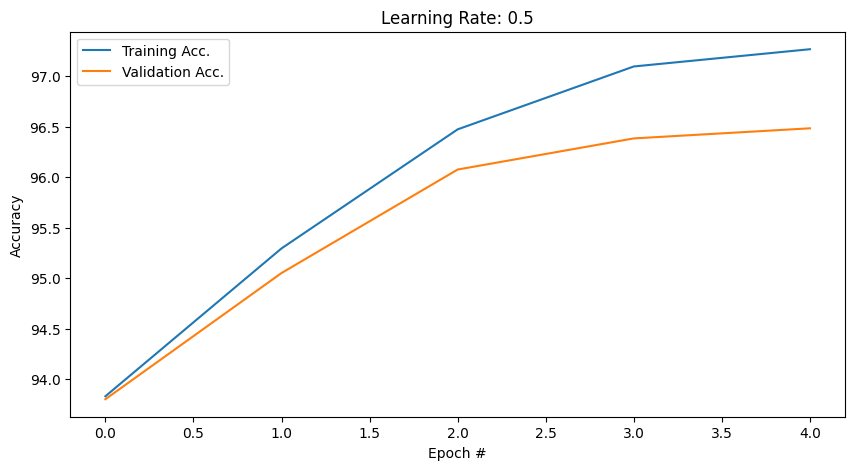

In [31]:
# Hyperparameters (constant batch size and activation function)
batch_size = 128
activation_function = nn.ReLU()

# Different learning rates to test
learning_rates = [0.01, 0.05, 0.1, 0.5]
epochs = 5

for lr in learning_rates:
    # Initialize dataloaders for the current batch size
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

    # Model, loss function, and optimizer with the current learning rate
    nonlinear_model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 50),
        activation_function,
        nn.Dropout(0.2),
        nn.Linear(50, 50),
        activation_function,
        nn.Linear(50, 10)
    )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=lr)

    train_acc_all, val_acc_all = [], []

    # Training loop
    for j in range(epochs):
        train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

        # Training evaluation
        acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
        train_acc_all.append(acc)
        print(f"Learning Rate {lr}, Epoch {j}: training loss: {loss}, accuracy: {acc}")

        # Validation evaluation
        val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
        val_acc_all.append(val_acc)
        print(f"Learning Rate {lr}, Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

    # Plotting results
    plt.figure(figsize=(10, 5))
    plt.plot(range(epochs), train_acc_all, label='Training Acc.')
    plt.plot(range(epochs), val_acc_all, label='Validation Acc.')
    plt.title(f'Learning Rate: {lr}')
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

**Testing Different Activation Functions**

Activation ReLU, Epoch 0: training loss: 0.509122294108073, accuracy: 86.48125
Activation ReLU, Epoch 0: val. loss: 0.5019302767642001, val. accuracy: 86.35000000000001
Activation ReLU, Epoch 1: training loss: 0.3553236435651779, accuracy: 90.07708333333333
Activation ReLU, Epoch 1: val. loss: 0.34538500756025314, val. accuracy: 90.10000000000001
Activation ReLU, Epoch 2: training loss: 0.2936773273944855, accuracy: 91.64999999999999
Activation ReLU, Epoch 2: val. loss: 0.28447484066511725, val. accuracy: 91.60000000000001
Activation ReLU, Epoch 3: training loss: 0.2569328699509303, accuracy: 92.60000000000001
Activation ReLU, Epoch 3: val. loss: 0.2507842519974455, val. accuracy: 92.48333333333333
Activation ReLU, Epoch 4: training loss: 0.22809713204701743, accuracy: 93.38333333333333
Activation ReLU, Epoch 4: val. loss: 0.22430013738414076, val. accuracy: 93.18333333333332


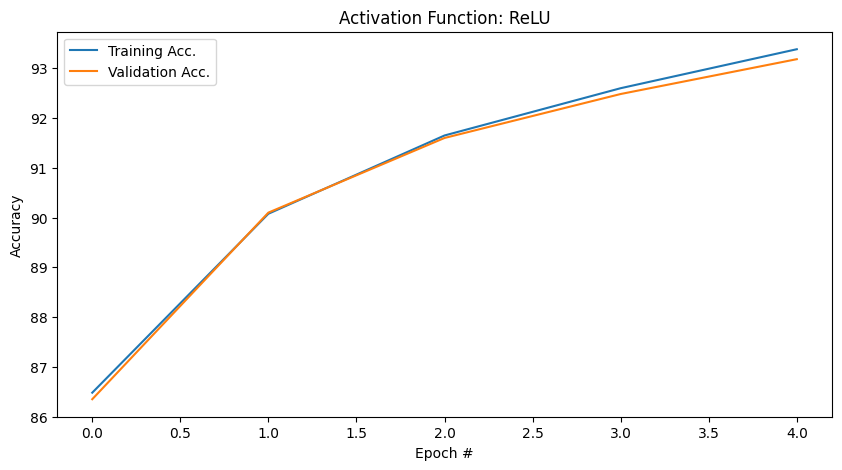

Activation LeakyReLU, Epoch 0: training loss: 0.5188057063420614, accuracy: 86.5
Activation LeakyReLU, Epoch 0: val. loss: 0.5100151928181343, val. accuracy: 86.25
Activation LeakyReLU, Epoch 1: training loss: 0.3531943585077921, accuracy: 90.18541666666667
Activation LeakyReLU, Epoch 1: val. loss: 0.3430460287218398, val. accuracy: 90.13333333333333
Activation LeakyReLU, Epoch 2: training loss: 0.29651466182867686, accuracy: 91.56875
Activation LeakyReLU, Epoch 2: val. loss: 0.28729995244995077, val. accuracy: 91.38333333333334
Activation LeakyReLU, Epoch 3: training loss: 0.26117271506786344, accuracy: 92.49166666666667
Activation LeakyReLU, Epoch 3: val. loss: 0.2537537096662724, val. accuracy: 92.33333333333333
Activation LeakyReLU, Epoch 4: training loss: 0.22823724134763082, accuracy: 93.37916666666666
Activation LeakyReLU, Epoch 4: val. loss: 0.223377248549715, val. accuracy: 93.41666666666667


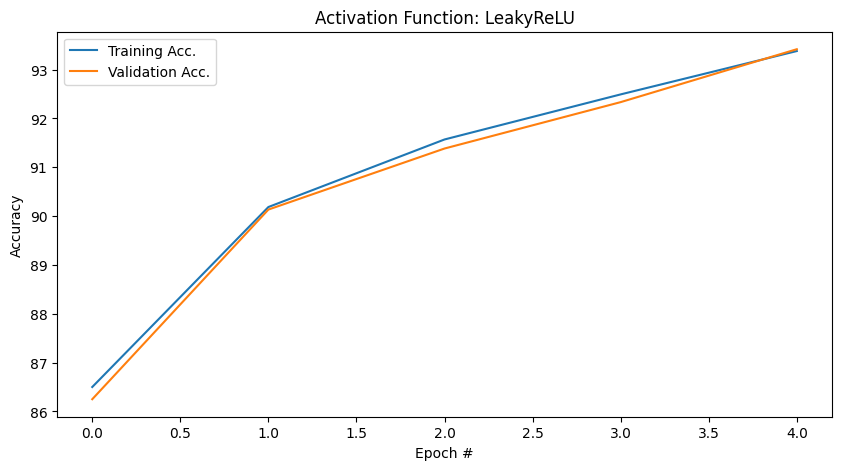

Activation Tanh, Epoch 0: training loss: 0.4956817830403646, accuracy: 87.39791666666666
Activation Tanh, Epoch 0: val. loss: 0.48847452059705204, val. accuracy: 87.6
Activation Tanh, Epoch 1: training loss: 0.3543239270846049, accuracy: 90.27916666666667
Activation Tanh, Epoch 1: val. loss: 0.3441399855816618, val. accuracy: 90.39166666666667
Activation Tanh, Epoch 2: training loss: 0.30647720889250435, accuracy: 91.37708333333333
Activation Tanh, Epoch 2: val. loss: 0.2979379613348778, val. accuracy: 91.44166666666666
Activation Tanh, Epoch 3: training loss: 0.27888429669539133, accuracy: 92.05833333333334
Activation Tanh, Epoch 3: val. loss: 0.2723248391709429, val. accuracy: 91.93333333333334
Activation Tanh, Epoch 4: training loss: 0.25781699339548747, accuracy: 92.58125
Activation Tanh, Epoch 4: val. loss: 0.25471867668501874, val. accuracy: 92.40833333333333


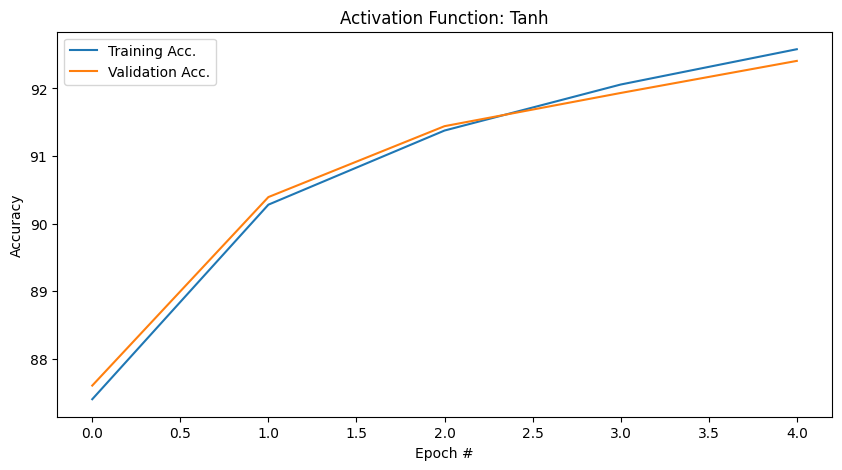

Activation ELU, Epoch 0: training loss: 0.4308188013235728, accuracy: 88.3875
Activation ELU, Epoch 0: val. loss: 0.42037583221780495, val. accuracy: 88.275
Activation ELU, Epoch 1: training loss: 0.33582209471861524, accuracy: 90.49791666666667
Activation ELU, Epoch 1: val. loss: 0.3253794125419982, val. accuracy: 90.48333333333333
Activation ELU, Epoch 2: training loss: 0.29851027592023216, accuracy: 91.44583333333334
Activation ELU, Epoch 2: val. loss: 0.28996943381238494, val. accuracy: 91.43333333333334
Activation ELU, Epoch 3: training loss: 0.2738644206325213, accuracy: 92.16041666666666
Activation ELU, Epoch 3: val. loss: 0.2676960588928233, val. accuracy: 92.07499999999999
Activation ELU, Epoch 4: training loss: 0.25305989843606946, accuracy: 92.71249999999999
Activation ELU, Epoch 4: val. loss: 0.2503048009536368, val. accuracy: 92.525


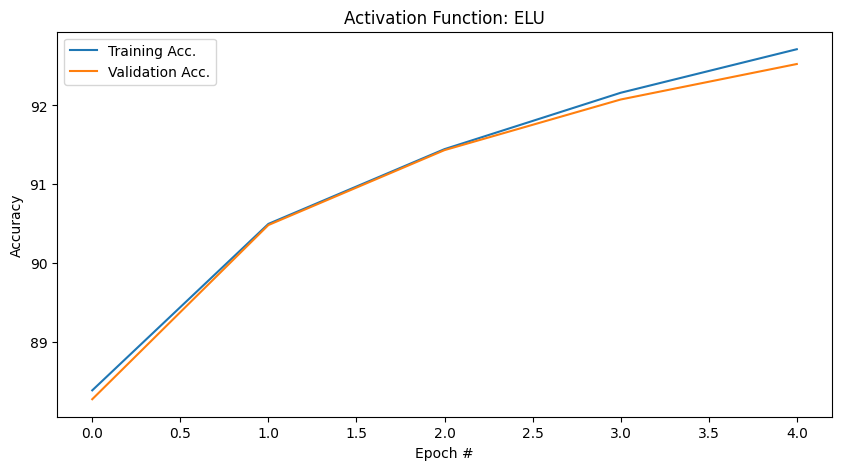

In [32]:
# Hyperparameters (constant batch size and learning rate)
batch_size = 128
learning_rate = 0.05

# Different activation functions to test
activation_functions = [nn.ReLU(), nn.LeakyReLU(), nn.Tanh(), nn.ELU()]
epochs = 5

for activation in activation_functions:
    # Initialize dataloaders for the current batch size
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

    # Model, loss function, and optimizer with the current activation function
    nonlinear_model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 50),
        activation,
        nn.Dropout(0.2),
        nn.Linear(50, 50),
        activation,
        nn.Linear(50, 10)
    )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=learning_rate)

    train_acc_all, val_acc_all = [], []

    # Training loop
    for j in range(epochs):
        train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

        # Training evaluation
        acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
        train_acc_all.append(acc)
        print(f"Activation {activation.__class__.__name__}, Epoch {j}: training loss: {loss}, accuracy: {acc}")

        # Validation evaluation
        val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
        val_acc_all.append(val_acc)
        print(f"Activation {activation.__class__.__name__}, Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

    # Plotting results
    plt.figure(figsize=(10, 5))
    plt.plot(range(epochs), train_acc_all, label='Training Acc.')
    plt.plot(range(epochs), val_acc_all, label='Validation Acc.')
    plt.title(f'Activation Function: {activation.__class__.__name__}')
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

2. A learning rate scheduler is a technique used in training neural networks to dynamically adjust the learning rate during training.

Epoch 1/50: Training loss: 0.3495, Accuracy: 90.20
Epoch 1/50: Validation loss: 0.3386, Accuracy: 90.03
Epoch 1/50: Current learning rate: 0.1000
Epoch 2/50: Training loss: 0.2651, Accuracy: 92.25
Epoch 2/50: Validation loss: 0.2597, Accuracy: 92.08
Epoch 2/50: Current learning rate: 0.1000
Epoch 3/50: Training loss: 0.2102, Accuracy: 93.87
Epoch 3/50: Validation loss: 0.2107, Accuracy: 93.83
Epoch 3/50: Current learning rate: 0.1000
Epoch 4/50: Training loss: 0.1784, Accuracy: 94.74
Epoch 4/50: Validation loss: 0.1828, Accuracy: 94.36
Epoch 4/50: Current learning rate: 0.1000
Epoch 5/50: Training loss: 0.1622, Accuracy: 95.17
Epoch 5/50: Validation loss: 0.1698, Accuracy: 94.87
Epoch 5/50: Current learning rate: 0.1000
Epoch 6/50: Training loss: 0.1402, Accuracy: 95.88
Epoch 6/50: Validation loss: 0.1513, Accuracy: 95.34
Epoch 6/50: Current learning rate: 0.1000
Epoch 7/50: Training loss: 0.1257, Accuracy: 96.34
Epoch 7/50: Validation loss: 0.1391, Accuracy: 95.85
Epoch 7/50: Current 

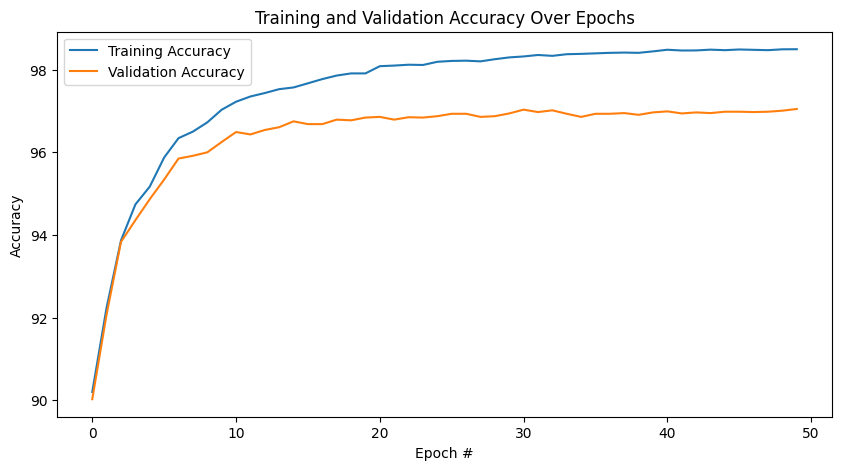

In [33]:
# Hyperparameters
batch_size = 128
initial_lr = 0.1
step_size = 10  # Number of epochs between learning rate decay
gamma = 0.5     # Factor to reduce learning rate by at each step
epochs = 50

# Data Loaders
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

# Define the Model
class NonlinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28 * 28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)
        return x

# Initialize the model, loss function, optimizer, and learning rate scheduler
model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Lists to store accuracy results for plotting
train_acc_all, val_acc_all = [], []

# Training Loop
for epoch in range(epochs):
    # Training phase
    train_one_epoch(train_dataloader, model, loss_fn, optimizer)

    # Evaluate on training data
    train_acc, train_loss = evaluate(train_dataloader, model, loss_fn)
    train_acc_all.append(train_acc)
    print(f"Epoch {epoch+1}/{epochs}: Training loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}")

    # Evaluate on validation data
    val_acc, val_loss = evaluate(val_dataloader, model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs}: Validation loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}")

    # Step the scheduler to update the learning rate
    scheduler.step()
    print(f"Epoch {epoch+1}/{epochs}: Current learning rate: {scheduler.get_last_lr()[0]:.4f}")

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_acc_all, label='Training Accuracy')
plt.plot(range(epochs), val_acc_all, label='Validation Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.show()